In [1]:
from pathlib import Path
import numpy as np
from itertools import cycle
from tqdm.notebook import tqdm
import torch
from torch.optim import SGD
import argparse
import h5py
import matplotlib.pyplot as plt

from adabmDCA.utils import get_device

from aiDCA.dataset import DatasetBin
from aiDCA.dataset import DataLoader_shuffle as DataLoader
from aiDCA.binary import aiRBMbin
from aiDCA.binary.stats import get_freq_single_point
from aiDCA.train import pcd

In [2]:
args = {
    "data" : "/home/lorenzo/Documents/FeF_temp/example_data/MNIST_train.dat",
    "output" : "/home/lorenzo/Documents/FeF_temp/models/MNIST",
    "model" : "binary",
    "annotations" : "/home/lorenzo/Documents/FeF_temp/example_data/MNIST_train_ann.csv",
    "hidden" : 100,
    "weights" : "/home/lorenzo/Documents/FeF_temp/models/MNIST/test_weights.dat",
    "path_params" : None,
    "path_chains" : None,
    "label" : "test",
    "lr" : 0.01,
    "gibbs_steps" : 10,
    "nchains" : 2000,
    "nepochs" : 10000,
    "pseudocount" : 1e-6,
    "centered" : True,
    "seed" : 0,
    "device" : "cuda",
    "dtype" : torch.float32,
}

In [3]:
device = get_device(args["device"])
print("\n")
print(f"Input MSA:\t\t{args['data']}")
print(f"Output folder:\t\t{args['output']}")
#print(f"Alphabet:\t\t{args['alphabet']}")
print(f"Learning rate:\t\t{args['lr']}")
print(f"Number of Gibbs Steps:\t{args['gibbs_steps']}")
if args['pseudocount'] is not None:
    print(f"Pseudocount:\t\t{args['pseudocount']}")
print(f"Random seed:\t\t{args['seed']}")
print("\n")

Running on NVIDIA RTX A5000


Input MSA:		/home/lorenzo/Documents/FeF_temp/example_data/MNIST_train.dat
Output folder:		/home/lorenzo/Documents/FeF_temp/models/MNIST
Learning rate:		0.01
Number of Gibbs Steps:	10
Pseudocount:		1e-06
Random seed:		0




In [4]:
# Create the folder where to save the model
folder = Path(args["output"])
folder.mkdir(parents=True, exist_ok=True)

In [5]:
if args["label"] is not None:
    file_paths = {
        "log" : folder / Path(f"{args['label']}.log"),
        "params" : folder / Path(f"{args['label']}_params.h5"),
        "chains" : folder / Path(f"{args['label']}_chains.fasta")
        }
    
else:
    file_paths = {
        "log" : folder / Path(f"adabmDCA.log"),
        "params" : folder / Path(f"params.h5"),
        "chains" : folder / Path(f"chains.fasta")
    }


In [6]:
# Import dataset
print("Importing dataset...")
dataset = DatasetBin(
    path_data=args["data"],
    path_weights=args["weights"],
    path_labels=args["annotations"],
    device=device,
)

Importing dataset...


In [7]:
rbm = aiRBMbin(
    device=device,
    dtype=args["dtype"],
)

In [9]:
# Initialize parameters
fi_visible = get_freq_single_point(
    data=dataset.data,
    weights=dataset.weights,
    pseudo_count=args["pseudocount"],
)

fi_label = get_freq_single_point(
    data=dataset.labels_one_hot,
    weights=dataset.weights,
    pseudo_count=args["pseudocount"],
)

rbm.init_parameters(
    num_hiddens=args["hidden"],
    num_visibles=dataset.get_num_residues(),
    num_labels=dataset.get_num_classes(),
    frequencies_visibles=fi_visible,
    frequencies_labels=fi_label,
    std_init=1e-6,
    device=device,
    dtype=args["dtype"],
)

In [10]:
# Save the weights if not already provided
if args["weights"] is None:
    if args["label"] is not None:
        path_weights = folder / f"{args["label"]}_weights.dat"
    else:
        path_weights = folder / "weights.dat"
    np.savetxt(path_weights, dataset.weights.cpu().numpy())
    print(f"Weights saved in {path_weights}")

In [11]:
torch.manual_seed(args["seed"])

# Shouffle the dataset
dataset.shuffle()

In [12]:
if args["pseudocount"] is None:
    args["pseudocount"] = 1 / dataset.get_effective_size()
    print(f"Pseudocount automatically set to {args["pseudocount"]}.")

In [13]:
# Initialize the chains
print(f"Number of chains and minibatch size set to {args["nchains"]}.")
chains = rbm.init_chains(
    num_samples=args["nchains"],
)

Number of chains and minibatch size set to 2000.


In [14]:
# Initialize gradients for the parameters
for key, value in rbm.params.items():
    value.grad = torch.zeros_like(value)

# Select the optimizer
optimizer = SGD(rbm.params.values(), lr=args["lr"], maximize=True)

In [15]:
# Dataloader
dataloader = DataLoader(
    dataset,
    batch_size=args["nchains"],
    shuffle=True,
    drop_last=True,
)
# Allows to iterate indefinitely on the dataloader without worrying on the epochs
dataloader = cycle(dataloader)

In [16]:
# Save the hyperparameters of the model
template = "{0:20} {1:10}\n"  
with open(file_paths["log"], "w") as f:
    if args["label"] is not None:
        f.write(template.format("label:", args["label"]))
    else:
        f.write(template.format("label:", "N/A"))
        
    f.write(template.format("model:", str(args["model"])))
    f.write(template.format("num hidden:", args["hidden"]))
    f.write(template.format("input MSA:", str(args["data"])))
    f.write(template.format("nchains:", args["nchains"]))
    f.write(template.format("gibbs_steps:", args["gibbs_steps"]))
    f.write(template.format("lr:", args["lr"]))
    f.write(template.format("pseudo count:", args["pseudocount"]))
    f.write(template.format("centered:", args["centered"]))
    f.write(template.format("num epochs:", args["nepochs"]))
    f.write(template.format("random seed:", args["seed"]))
    f.write("\n")
    #template = "{0:10} {1:10} {2:10} {3:10} {4:10} {5:10} {6:10}\n"
    #f.write(template.format("Epoch", "Pearson", "Slope", "LL", "Entropy", "Density", "Time [s]"))

In [17]:
# Training cycle
pbar = tqdm(initial=0, total=args["nepochs"], colour="red", dynamic_ncols=True, ascii="-#")
upd = 0
with torch.no_grad():
    while upd < args["nepochs"]:
        
        if upd % 10 == 0:
            pbar.update(10)
            
        # Get the next batch
        batch = next(dataloader)
        optimizer.zero_grad(set_to_none=False)
        chains = pcd(
            rbm=rbm,
            data_batch=batch,
            chains=chains,
            gibbs_steps=args["gibbs_steps"],
            pseudo_count=args["pseudocount"],
            centered=args["centered"],
        )
        
        # Update the parameters
        optimizer.step()
        
        if upd % 100 == 0:
            rbm.save(
                filename=file_paths["params"],
                num_updates=upd,
            )
            rbm.save_chains(
                filename=file_paths["chains"],
                visible=chains["visible"],
                label=chains["label"],
            )
            
        upd += 1


  0%|          | 0/10000 [00:00<?, ?it/s]

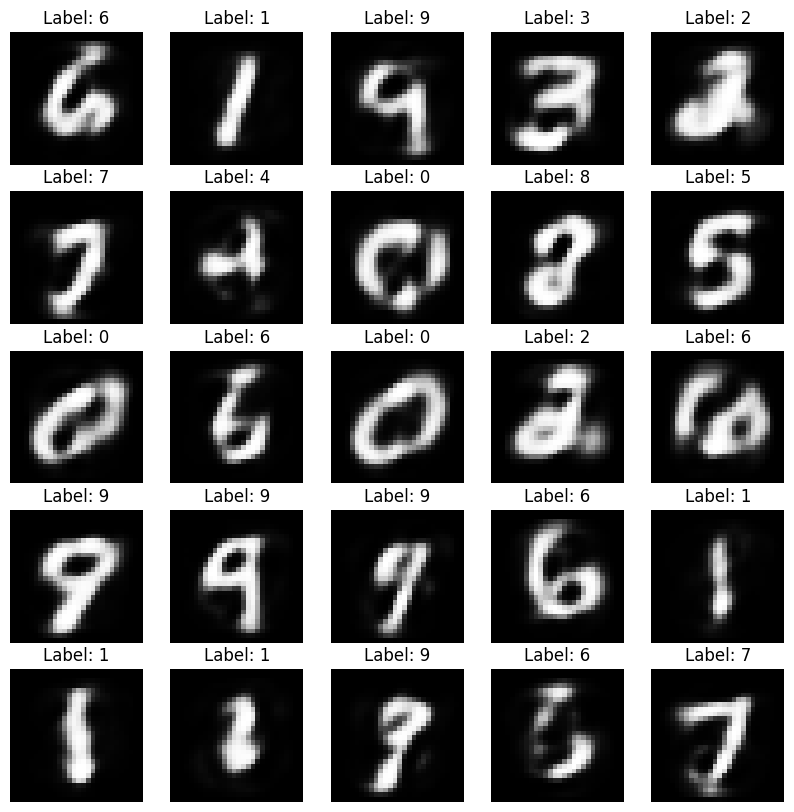

In [ ]:
# Take the first 25 chains and plot the visible units in a 5x5 grid for visualizing the MNIST digits
import matplotlib.pyplot as plt

# Take the first 25 chains
mh = rbm.sample_hiddens(**chains)["hidden_mag"]
mv = rbm.sample_visibles(**chains)["visible_mag"]

l = rbm.sample_labels(**chains)["label_mag"]
first_25_labels = dataset.to_label(l)[:25]
first_25_chains = mv[:25].cpu().numpy()


# Plot the visible units in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(first_25_chains[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {first_25_labels[i]}")
    ax.axis('off')

plt.show()

### Investigate the model

In [19]:
from scipy.linalg import svd

fname_model = "/home/lorenzo/Documents/FeF_temp/models/MNIST/test_params.h5"

def get_eigenvalues_history(filename):
    f = h5py.File(filename, 'r')
    updates = []
    eigenvalues = []
    for key in f.keys():
        if "update" in key:
            weight_matrix = f[key]["weight_matrix"][()]
            weight_matrix = weight_matrix.reshape(-1, weight_matrix.shape[-1])
            eig = svd(weight_matrix, compute_uv=False)
            eigenvalues.append(eig.reshape(*eig.shape, 1))
            updates.append(int(key.split("_")[1]))
    
    # Sort the results
    sorting = np.argsort(updates)
    updates = np.array(updates)[sorting]
    eigenvalues = np.array(np.hstack(eigenvalues).T)[sorting]
    f.close()
            
    return updates, eigenvalues

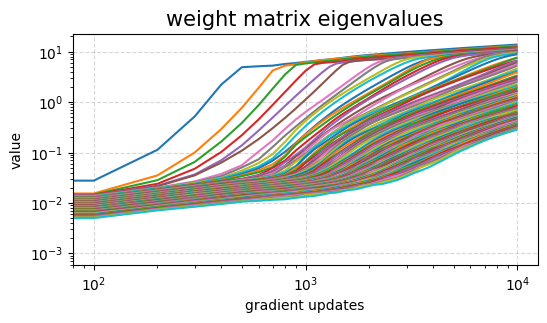

In [21]:
updates, eigenvalues = get_eigenvalues_history(fname_model)

fig, ax = plt.subplots(dpi=100, nrows=1, ncols=1, figsize=(6, 3))
ax.set_title('weight matrix eigenvalues', size=15)
ax.set_xlabel('gradient updates')
ax.set_ylabel('value')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.5, ls='dashed')
ax.plot(updates, eigenvalues);